## Project 2: Hybrid Recommendation System 
**Name:** Krisha Mahat

**Student Id:** 300368184

**References**
- Surprise Library Documentation: https://surprise.readthedocs.io/
- https://medium.com/@imeshadilshani212/building-a-content-based-movie-recommender-system-with-cosine-similarity-557d3c78ca8f
- https://medium.com/@saibhargavkarnati/movie-recommendation-system-using-machine-learning-8f6393d71c83
- https://a-elkhattam.medium.com/imdb-movie-recommendation-chatbot-942f84dfa0dc

Objective:
To create a hybrid movie recommendation system that predicts and ranks movies based on user preferences and movie attributes.

## Data Processing

Here, I will Prepare the ratings, movies, Tags, and link datasets by cleaning, transforming, and combining relevant data.

### a. Import all the required libraries 

In [5]:
pip install scikit-surprise

Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from surprise import Dataset, Reader, SVD, KNNBasic, accuracy
from surprise.model_selection import train_test_split
from collections import defaultdict
from sklearn.metrics import mean_squared_error
from Modules.Modules_KMa184 import compute_tag_similarity



Surprise Library: This Library will be used for collaborative filtering algorithms in recommendation systems.
This Library has Pre-built algorithms for user-based and item-based recommendations. References: https://surprise.readthedocs.io/en/stable/

TfidfVectorizer (from scikit-learn):This Library converts text data into numerical vectors for calculating the similarity between items.

cosine_similarity (from scikit-learn): This Library aims to measure similarity between data points using cosine distance.
References: https://memgraph.com/blog/cosine-similarity-python-scikit-learn

### b. Load Data

In [9]:
# Loading each file into a DataFrame
movies_df = pd.read_csv("dataset/movies.csv")
ratings_df = pd.read_csv("dataset/ratings.csv")
tags_df = pd.read_csv("dataset/tags.csv")
links_df = pd.read_csv("dataset/links.csv")


### c.  Inspect the Data and check for missing values

In [11]:
# Check the first few rows of each DataFrame
print("Movies DataFrame:")
print(movies_df.head())

print("\nRatings DataFrame:")
print(ratings_df.head())

print("\nTags DataFrame:")
print(tags_df.head())

print("\nLinks DataFrame:")
print(links_df.head())

# Check for missing values
print("Missing values in Movies DataFrame:")
print(movies_df.isnull().sum())

print("\nMissing values in Ratings DataFrame:")
print(ratings_df.isnull().sum())

print("\nMissing values in Tags DataFrame:")
print(tags_df.isnull().sum())

print("\nMissing values in Links DataFrame:")
print(links_df.isnull().sum())

# Check for duplicates
print("\nDuplicate rows in Ratings DataFrame:", ratings_df.duplicated().sum())
print("Duplicate rows in Tags DataFrame:", tags_df.duplicated().sum())
print("\nDuplicate rows in Movies DataFrame:", movies_df.duplicated().sum())
print("Duplicate rows in Links DataFrame:", links_df.duplicated().sum())

Movies DataFrame:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  

Ratings DataFrame:
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931

Tags DataFrame:
   userId  movieId              tag   timestamp
0       2    60756            funny  1445714994
1       2    60756  Highly

### d. Process columns 

In [13]:
# Split genres into lists
movies_df['genres'] = movies_df['genres'].apply(lambda x: x.split('|'))
# Merge datasets for combined analysis
merged_df = pd.merge(ratings_df, movies_df, on="movieId")

# Fill missing values in genres
movies_df['genres'] = movies_df['genres'].fillna('') 
# Convert timestamps to datetime
ratings_df['timestamp'] = pd.to_datetime(ratings_df['timestamp'], unit='s')
tags_df['timestamp'] = pd.to_datetime(tags_df['timestamp'], unit='s')

def preprocess_tags(tags_df):
    tags_df['tag'] = tags_df['tag'].fillna('').str.lower()  # Handle missing tags and lowercase
    tag_agg = tags_df.groupby('movieId')['tag'].apply(lambda x: ' '.join(x)).reset_index()  # Combine tags for each movie
    return tag_agg


## 2.  Exploratory Data Analysis (EDA)

### a. Summary Statistics

In [16]:

print("Movies Summary Statistics:")
print(movies_df.describe())

print("\nRatings Summary Statistics:")
print(ratings_df.describe())

print("\nTags Summary Statistics:")
print(tags_df.describe())

print("\nLink Summary Statistics:")
print(links_df.describe())

Movies Summary Statistics:
             movieId
count    9742.000000
mean    42200.353623
std     52160.494854
min         1.000000
25%      3248.250000
50%      7300.000000
75%     76232.000000
max    193609.000000

Ratings Summary Statistics:
              userId        movieId         rating  \
count  100836.000000  100836.000000  100836.000000   
mean      326.127564   19435.295718       3.501557   
min         1.000000       1.000000       0.500000   
25%       177.000000    1199.000000       3.000000   
50%       325.000000    2991.000000       3.500000   
75%       477.000000    8122.000000       4.000000   
max       610.000000  193609.000000       5.000000   
std       182.618491   35530.987199       1.042529   

                           timestamp  
count                         100836  
mean   2008-03-19 17:01:27.368469248  
min              1996-03-29 18:36:55  
25%              2002-04-18 09:57:46  
50%              2007-08-02 20:31:02  
75%       2015-07-04 07:15:44.5000

### b. Visualization

#### a. Rating Distribution 
visualizing how the ratings are distributed across all movies. This will give us insights into user preferences.

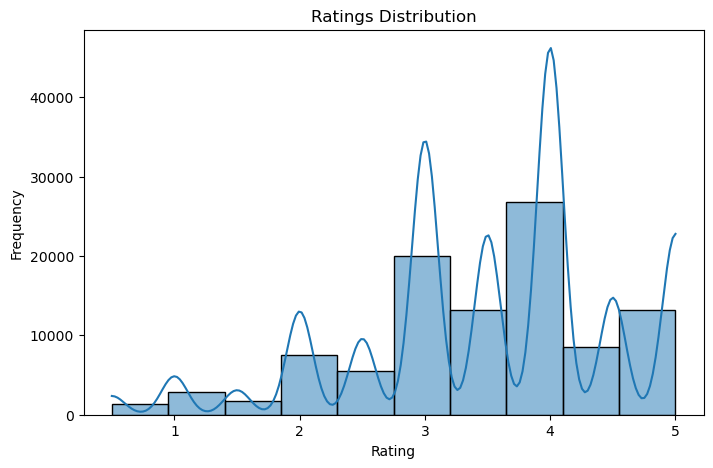

In [19]:
# ratings distribution
plt.figure(figsize=(8, 5))
sns.histplot(ratings_df['rating'], bins=10, kde=True)
plt.title("Ratings Distribution")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

**Interpretation**
The plot reveals that most movie ratings cluster around 3 and 4, with fewer extreme ratings (1 or 5). This indicates a tendency for users to rate movies moderately.

#### b. Average Rating per Movie
Identify the most and least popular movies by their average rating. 

In [22]:
# Calculate average rating per movie
avg_ratings = ratings_df.groupby('movieId')['rating'].mean()
# Getting the top 10 highest-rated movies
top_rated_movies = avg_ratings.sort_values(ascending=False).head(10)
top_rated_with_titles = top_rated_movies.reset_index().merge(movies_df[['movieId', 'title']], on='movieId')
print("\nTop 10 Highest-Rated Movies:")
print(top_rated_with_titles[['title', 'rating']])

# Getting the bottom 10 lowest-rated movies
lowest_rated_movies = avg_ratings.sort_values().head(10)
lowest_rated_with_titles = lowest_rated_movies.reset_index().merge(movies_df[['movieId', 'title']], on='movieId')
print("\nTop 10 Lowest-Rated Movies:")
print(lowest_rated_with_titles[['title', 'rating']])



Top 10 Highest-Rated Movies:
                                       title  rating
0      Paper Birds (Pájaros de papel) (2010)     5.0
1                 Act of Killing, The (2012)     5.0
2                            Jump In! (2007)     5.0
3                               Human (2015)     5.0
4                        L.A. Slasher (2015)     5.0
5                           Lady Jane (1986)     5.0
6             Bill Hicks: Revelations (1993)     5.0
7               Justice League: Doom (2012)      5.0
8  Open Hearts (Elsker dig for evigt) (2002)     5.0
9                     Formula of Love (1984)     5.0

Top 10 Lowest-Rated Movies:
                                   title  rating
0                       Lionheart (1990)     0.5
1                           Gypsy (1962)     0.5
2                Follow Me, Boys! (1966)     0.5
3                  Idaho Transfer (1973)     0.5
4                         Case 39 (2009)     0.5
5     Bloodsport: The Dark Kumite (1999)     0.5
6           Har

**Interpretation**

- Notable titles with perfect scores (5.0) include Paper Birds (2010) and The Act of Killing (2012), typically niche or highly artistic productions.
- Movies like The Emoji Movie (2017) and Yongary: Monster from the Deep (1967) received the lowest ratings, reflecting poor reception or quality.

#### c. Movie Popularity by Number of Ratings


Top 10 Most Rated Movies:
                                       title  rating_count
0                        Forrest Gump (1994)           329
1           Shawshank Redemption, The (1994)           317
2                        Pulp Fiction (1994)           307
3           Silence of the Lambs, The (1991)           279
4                         Matrix, The (1999)           278
5  Star Wars: Episode IV - A New Hope (1977)           251
6                       Jurassic Park (1993)           238
7                          Braveheart (1995)           237
8          Terminator 2: Judgment Day (1991)           224
9                    Schindler's List (1993)           220


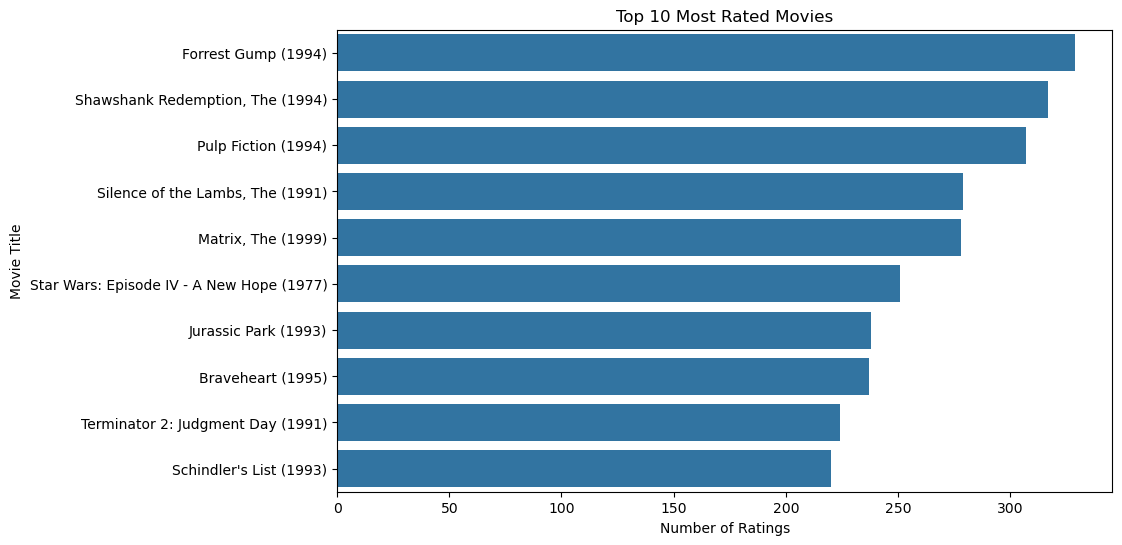

In [25]:
# Count ratings per movie and get the top 10 most rated movies
movie_rating_counts = ratings_df['movieId'].value_counts().head(10).reset_index()
movie_rating_counts.columns = ['movieId', 'rating_count']  # Rename for clarity

# Merge with movies_df to get titles
most_rated_with_titles = movie_rating_counts.merge(movies_df[['movieId', 'title']], on='movieId', how='left')

print("\nTop 10 Most Rated Movies:")
print(most_rated_with_titles[['title', 'rating_count']])

# Plot the results
plt.figure(figsize=(10, 6))
sns.barplot(x='rating_count', y='title', data=most_rated_with_titles)
plt.title("Top 10 Most Rated Movies")
plt.xlabel("Number of Ratings")
plt.ylabel("Movie Title")
plt.show()


**Interpretation**

Forrest Gump (1994) is the most rated movie with 329 ratings, followed closely by The Shawshank Redemption (1994) and Pulp Fiction (1994). These classics indicate strong user engagement and cultural impact.

#### d. Popular Genres
Examining the genre data to find out which genres are most frequently represented.


Top 10 Genres by Count:
genres
Drama        4361
Comedy       3756
Thriller     1894
Action       1828
Romance      1596
Adventure    1263
Crime        1199
Sci-Fi        980
Horror        978
Fantasy       779
Name: count, dtype: int64


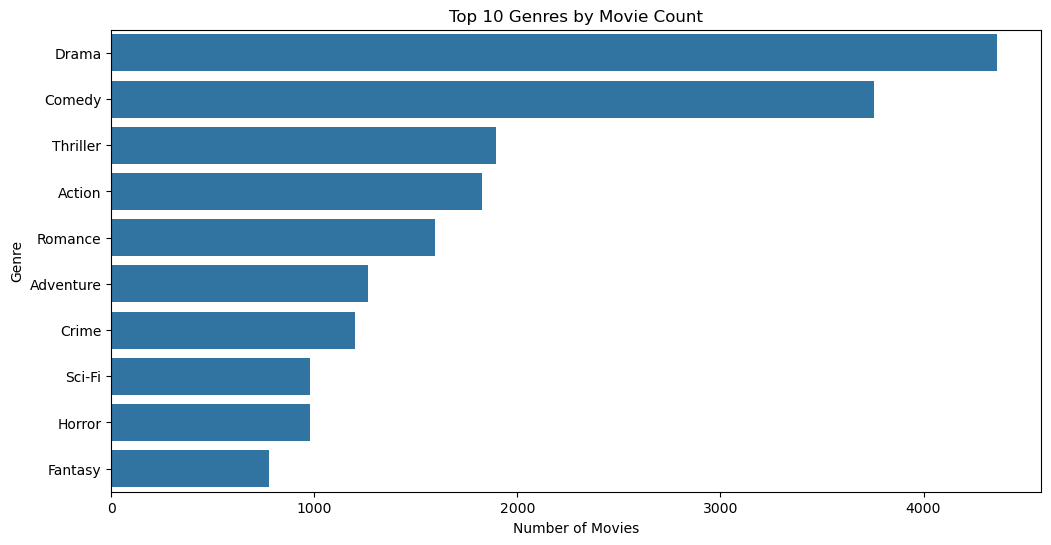

In [28]:
# Expand genres column and count each genre
all_genres = movies_df['genres'].explode()  # Splits lists into rows
genre_counts = all_genres.value_counts()

# Display top 10 genres
print("\nTop 10 Genres by Count:")
print(genre_counts.head(10))

# Plot genre popularity
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.values[:10], y=genre_counts.index[:10])
plt.title("Top 10 Genres by Movie Count")
plt.xlabel("Number of Movies")
plt.ylabel("Genre")
plt.show()


**Interpretation**
Drama and Comedy are the most prevalent genres, indicating their dominance in the movie catalog. Action and Romance follow, showcasing the audience's preference for diverse storytelling.

#### e. User Behavior
Understand user interaction


Ratings per User Statistics:
count     610.000000
mean      165.304918
std       269.480584
min        20.000000
25%        35.000000
50%        70.500000
75%       168.000000
max      2698.000000
Name: count, dtype: float64


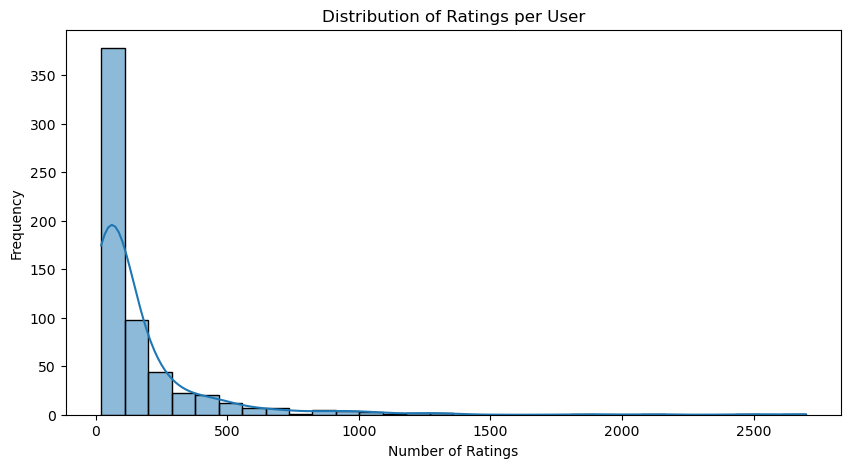

In [31]:
# Count ratings per user
user_rating_counts = ratings_df['userId'].value_counts()

# Summary statistics for ratings per user
print("\nRatings per User Statistics:")
print(user_rating_counts.describe())

# Plot distribution of ratings per user
plt.figure(figsize=(10, 5))
sns.histplot(user_rating_counts, bins=30, kde=True)
plt.title("Distribution of Ratings per User")
plt.xlabel("Number of Ratings")
plt.ylabel("Frequency")
plt.show()


**Interpretation**

The average number of ratings per user is approximately 165, but this distribution is highly skewed, as some users have rated over 2,000 movies.

#### f. Visualize Rating Distributions per Genre

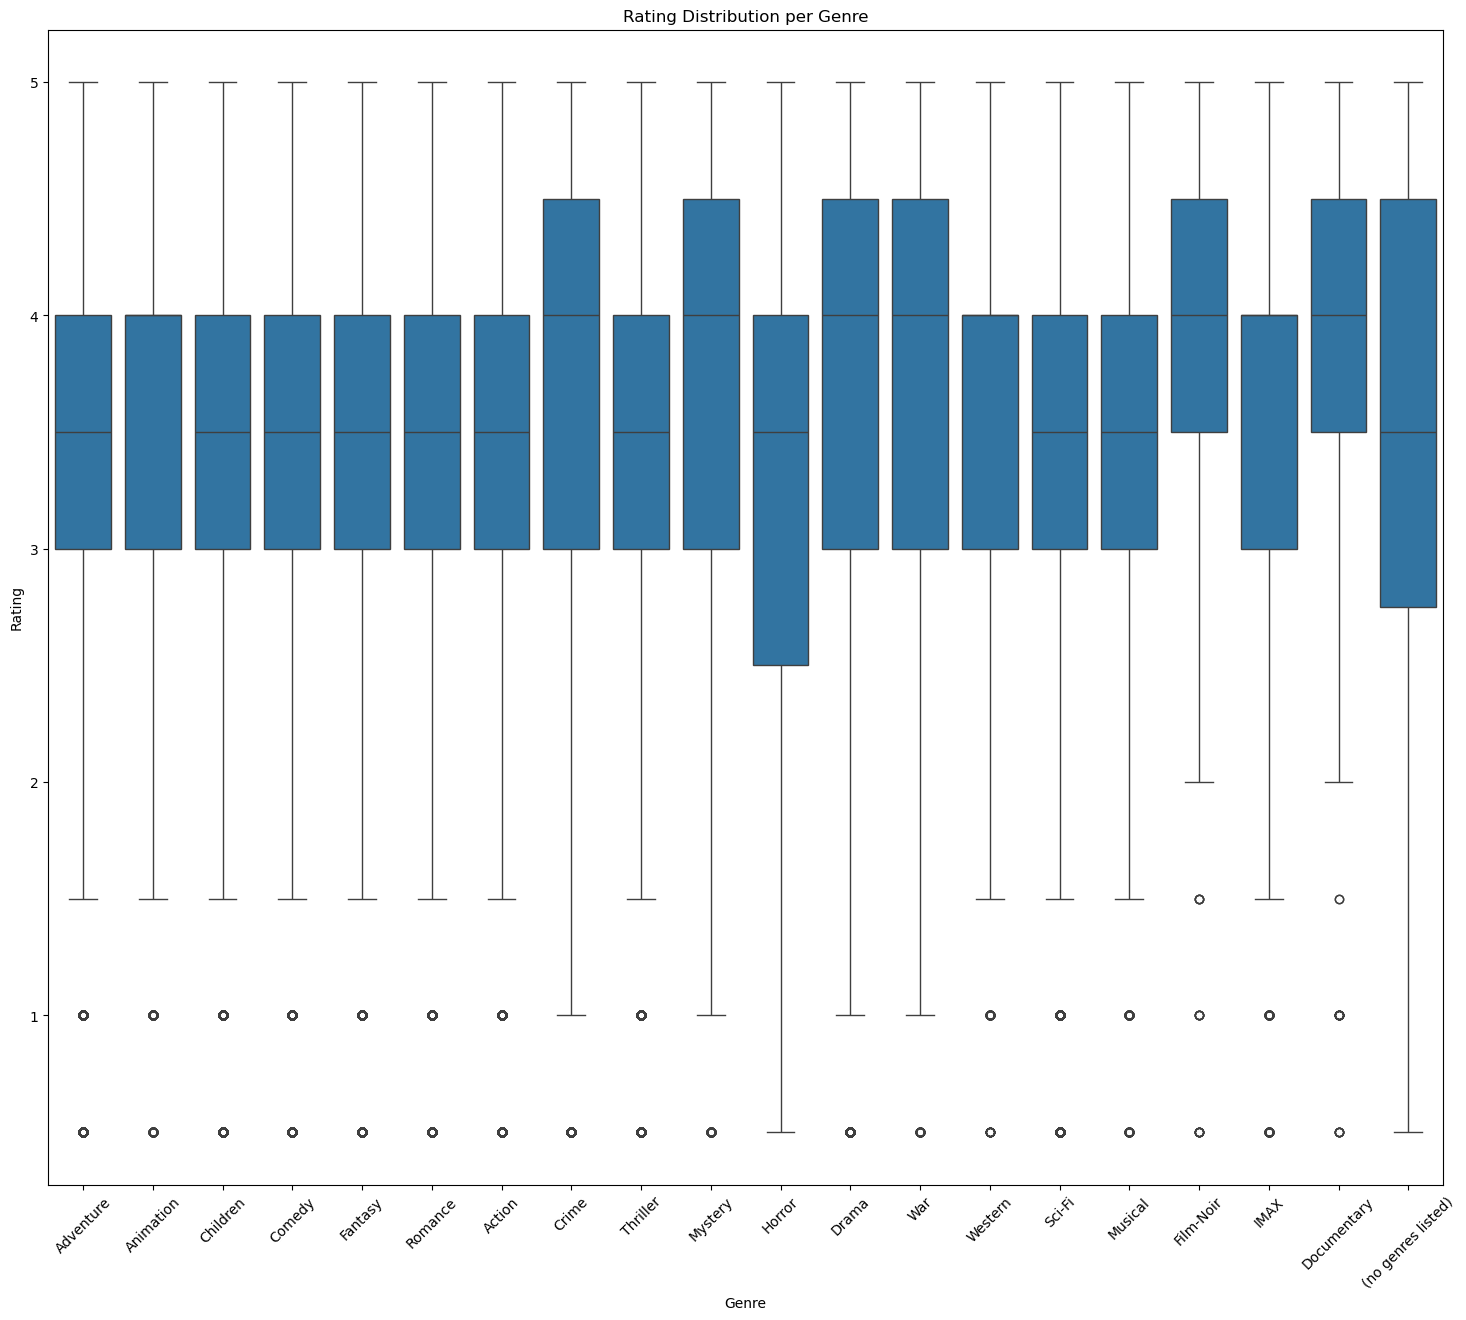

In [34]:
# Step 1: Merge Ratings and Movies on movieId
ratings_with_genres = pd.merge(ratings_df, movies_df, on='movieId')

# Step 2: Explode genres to separate rows for each genre
ratings_with_genres = ratings_with_genres.explode('genres')

# Step 3: Plot Rating Distributions per Genre
plt.figure(figsize=(18, 15))
sns.boxplot(data=ratings_with_genres, x='genres', y='rating')
plt.title('Rating Distribution per Genre')
plt.xlabel('Genre')
plt.ylabel('Rating')
plt.xticks(rotation=45)
plt.show()

**Interpretation**

Boxplots show that Drama and Documentary genres have a wide spread of ratings, while Mystery tends to have lower median ratings. Certain genres, like Animation and War, have higher median ratings, indicating better overall reception.

### Feature  Engineering
 Here we will generates numerical vectors for movie genres using TF-IDF and computes genre similarity.

In [37]:

# Convert genres column to strings with '|' delimiter
movies_df['genres'] = movies_df['genres'].apply(lambda x: '|'.join(x) if isinstance(x, list) else x)

C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Genre Similarity Matrix:
[[1.         0.81357774 0.15276924 ... 0.         0.4210373  0.26758648]
 [0.81357774 1.         0.         ... 0.         0.         0.        ]
 [0.15276924 0.         1.         ... 0.         0.         0.57091541]
 ...
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.4210373  0.         0.         ... 0.         1.         0.        ]
 [0.26758648 0.         0.57091541 ... 0.         0.         1.        ]]


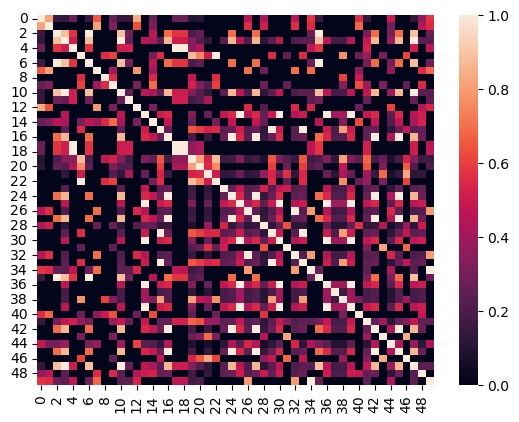

In [38]:
# Compute genre similarity using TF-IDF
# "Term Frequency-Inverse Document Frequency" is used here to convert genres into a numerical
#representation based on their importance across movies.
tfidf_vectorizer = TfidfVectorizer(tokenizer=lambda x: x.split('|'))
tfidf_matrix = tfidf_vectorizer.fit_transform(movies_df['genres'])

# Calculate cosine similarity
#Measures the similarity between movies based on their TF-IDF genre vectors.
# Cosine similarity values range from 0 (completely dissimilar) to 1 (identical genres).
genre_similarity = cosine_similarity(tfidf_matrix)

sns.heatmap(genre_similarity[:50, :50])
# Display similarity matrix for verification
print("Genre Similarity Matrix:")
print(genre_similarity)

# Process Tags
tags_agg = preprocess_tags(tags_df)
tag_similarity_matrix = compute_tag_similarity(tags_agg)


### Collaborative Filtering - (User based and Item based)
Implementing user-based and item-based recommendation models using the Surprise library.

In [40]:
# Step 4: Collaborative Filtering - User-Based and Item-Based
#Converts the ratings data into a format required for the Surprise library's collaborative filtering models.
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)

# Train-Test Split
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# User-Based Collaborative Filtering
user_cf_model = KNNBasic(sim_options={'user_based': True})
user_cf_model.fit(trainset)

# Item-Based Collaborative Filtering
item_cf_model = KNNBasic(sim_options={'user_based': False})
item_cf_model.fit(trainset)



Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


### Model evaluation
Measuring model performance using RMSE.

In [42]:
#Model Evaluation
def evaluate_model(model, trainset, testset):
    predictions = model.test(testset)
    rmse = accuracy.rmse(predictions)
    return rmse

# Evaluate Models
print("User Based Model: ")
user_cf_rmse = evaluate_model(user_cf_model, trainset, testset)
print("Item Based Model: ")
item_cf_rmse = evaluate_model(item_cf_model, trainset, testset)


User Based Model: 
RMSE: 0.9578
Item Based Model: 
RMSE: 0.9123


The item-based model has lower RMSE so it performs slightly better than the user-based model.

User Based Model


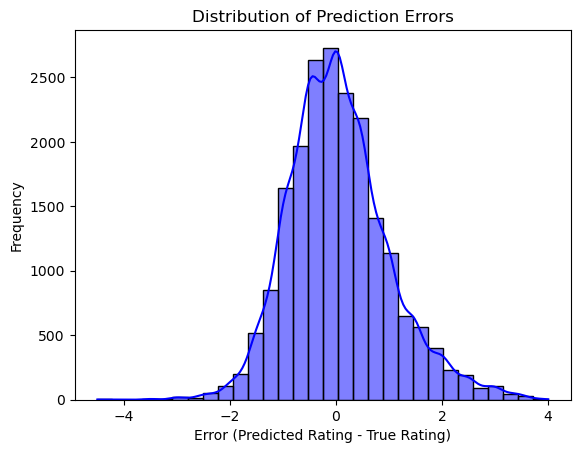

Item Based Model


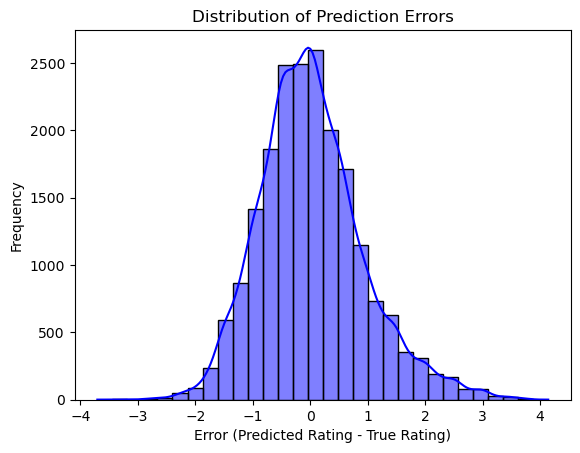

In [44]:
def plot_prediction_errors(predictions):
    errors = [pred.est - pred.r_ui for pred in predictions]  # Predicted rating - True rating
    sns.histplot(errors, kde=True, bins=30, color="blue")
    plt.title("Distribution of Prediction Errors")
    plt.xlabel("Error (Predicted Rating - True Rating)")
    plt.ylabel("Frequency")
    plt.show()

# Example for User-Based Model
user_predictions = user_cf_model.test(testset)
print("User Based Model")
plot_prediction_errors(user_predictions)

# Example for Item-Based Model
item_predictions = item_cf_model.test(testset)
print("Item Based Model")
plot_prediction_errors(item_predictions)

### Hybrid Recommendation Model
This code implements a hybrid recommendation system that combines content-based filtering (using genre and tag similarities) and collaborative filtering (user-based and item-based) to generate movie recommendations for a new user. 

In [46]:
# Hybrid Recommendation System Function
def hybrid_recommendation_for_new_user(user_id, user_cf_model, item_cf_model, tag_similarity_matrix, tags_agg, genre_similarity, testset, top_n=10):
    # Step 1: Content-based Recommendations (Genre and Tag-Based)
    genre_similarities = genre_similarity[:10, :]
    genre_based_recommendations = []
    
    #genre-based preference
    for i, similarity in enumerate(genre_similarities[user_id]):
        genre_based_recommendations.append((i, similarity))
    
    genre_based_recommendations.sort(key=lambda x: x[1], reverse=True)
    top_genre_recommendations = [movie_id for movie_id, _ in genre_based_recommendations[:top_n]]

    # Step 2: Content-based Recommendations (Tag-Based)
    tag_based_recommendations = []
    for movie_id in top_genre_recommendations:
        if movie_id in tags_agg.index:
            tag_similarity_score = tag_similarity_matrix[user_id, movie_id]
            tag_based_recommendations.append((movie_id, tag_similarity_score))
    
    tag_based_recommendations.sort(key=lambda x: x[1], reverse=True)

    #Collaborative Filtering Predictions (User-Based and Item-Based)
    user_cf_preds = {pred.iid: pred.est for pred in user_cf_model.test(testset) if pred.uid == user_id}
    item_cf_preds = {pred.iid: pred.est for pred in item_cf_model.test(testset) if pred.uid == user_id}

    hybrid_scores = defaultdict(float)
    for movie_id in user_cf_preds:
        hybrid_scores[movie_id] += 0.5 * user_cf_preds.get(movie_id, 0)
    for movie_id in item_cf_preds:
        hybrid_scores[movie_id] += 0.5 * item_cf_preds.get(movie_id, 0)
    
    #Add Tag-Based Similarity to Hybrid Scores
    if user_id in tags_agg.index:
        user_movie_index = tags_agg[tags_agg['movieId'].isin(user_cf_preds.keys())].index.tolist()
        for idx in user_movie_index:
            similarity_score = tag_similarity_matrix[user_id, idx]
            movie_id = tags_agg.loc[idx, 'movieId']
            hybrid_scores[movie_id] += 0.3 * similarity_score

    #Combine genre-based, tag-based, and collaborative filtering scores
    combined_recommendations = defaultdict(float)
    for movie_id, score in genre_based_recommendations:
        combined_recommendations[movie_id] += 0.8 * score
    for movie_id, score in tag_based_recommendations:
        combined_recommendations[movie_id] += 0.6 * score
    for movie_id, score in hybrid_scores.items():
        combined_recommendations[movie_id] += 0.5 * score

    final_recommendations = sorted(combined_recommendations.items(), key=lambda x: x[1], reverse=True)[:top_n]
    
    return [movie_id for movie_id, _ in final_recommendations], hybrid_scores, user_cf_preds, item_cf_preds

#Precision and Recall Evaluation
def precision_recall_at_n(recommendations, testset, top_n=10):
    relevant_count = 0
    recommended_count = 0
    total_relevant = 0

    actual_ratings = defaultdict(list)
    for user, movie, rating in testset:
        if rating >= 4:  # Consider ratings >= 4 as relevant
            actual_ratings[user].append(movie)

    for user, recommended_movies in recommendations.items():
        recommended_count += len(recommended_movies)
        relevant_count += len(set(recommended_movies) & set(actual_ratings[user]))
        total_relevant += len(actual_ratings[user])

    precision = relevant_count / recommended_count if recommended_count > 0 else 0
    recall = relevant_count / total_relevant if total_relevant > 0 else 0
    return precision, recall

# RMSE Evaluation
def compute_rmse(hybrid_scores, testset):
    y_true = []
    y_pred = []

    for user, movie, true_rating in testset:
        if movie in hybrid_scores:
            y_true.append(true_rating)
            y_pred.append(hybrid_scores[movie])

    return np.sqrt(mean_squared_error(y_true, y_pred))



#### Hybrid model evaluation

In [48]:
# Example Usage
test_user_id = 1  # Specify the user ID to test
recommendations, hybrid_scores, user_cf_preds, item_cf_preds = hybrid_recommendation_for_new_user(
    user_id=test_user_id,
    user_cf_model=user_cf_model,
    item_cf_model=item_cf_model,
    tag_similarity_matrix=tag_similarity_matrix,
    tags_agg=tags_agg,
    genre_similarity=genre_similarity,
    testset=testset,
    top_n=10
)

# Format recommendations for evaluation
recommendations_dict = {test_user_id: recommendations}

# Output recommendations
print(f"Top recommendations for User {test_user_id}: {recommendations}")

# Evaluate Precision, Recall, and RMSE
precision, recall = precision_recall_at_n(recommendations_dict, testset, top_n=10)
print(f"Precision at 10: {precision}")
print(f"Recall at 10: {recall}")

rmse = compute_rmse(hybrid_scores, testset)
print(f"RMSE: {rmse}")


Top recommendations for User 1: [527, 780, 1127, 2528, 648, 2959, 260, 1213, 356, 2502]
Precision at 10: 0.7
Recall at 10: 0.15555555555555556
RMSE: 0.9947577603609387


### Out Of Sample Predection

In [50]:
#Creating a new dummy user
new_user_id = 9999

# Simulating ratings for more movies (10 movies, with random ratings for variety)
dummy_ratings = pd.DataFrame({
    'userId': [new_user_id] * 10,
    'movieId': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],  # Random movie IDs (replace with real IDs)
    'rating': [5, 4, 3, 2, 4, 5, 4, 3, 2, 4]  # Random ratings
})

# Simulating tags for the new user
dummy_tags = pd.DataFrame({
    'userId': [new_user_id] * 10,
    'movieId': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 
    'tag': ['action', 'comedy', 'drama', 'action', 'comedy', 'thriller', 'drama', 'action', 'comedy', 'horror'] 
})

# Adding the new user's data to the existing dataframes (ratings_df and tags_df)
ratings_df = pd.concat([ratings_df, dummy_ratings], ignore_index=True)
tags_df = pd.concat([tags_df, dummy_tags], ignore_index=True)

print(ratings_df.tail())  # Checking if new ratings are added
print(tags_df.tail())     # Checking if new tags are added

recommendations_for_new_user = hybrid_recommendation_for_new_user(
    user_id=test_user_id,
    user_cf_model=user_cf_model,
    item_cf_model=item_cf_model,
    tag_similarity_matrix=tag_similarity_matrix,
    tags_agg=tags_agg,
    genre_similarity=genre_similarity,
    testset=testset,
    top_n=10
)

recommended_movie_ids = recommendations_for_new_user[0]  # First element is the list of recommended movie IDs

print("Recommended movie IDs:", recommended_movie_ids)

# Map recommended movie IDs to titles
recommended_movie_titles = [
    movies_df[movies_df['movieId'] == movie_id]['title'].values[0]  # Getting the title for each movieId
    for movie_id in recommended_movie_ids  # Iterate over each movieId
]

print("Recommended Movies:", recommended_movie_titles)

        userId  movieId  rating timestamp
100841    9999        6     5.0       NaT
100842    9999        7     4.0       NaT
100843    9999        8     3.0       NaT
100844    9999        9     2.0       NaT
100845    9999       10     4.0       NaT
      userId  movieId       tag timestamp
3688    9999        6  thriller       NaT
3689    9999        7     drama       NaT
3690    9999        8    action       NaT
3691    9999        9    comedy       NaT
3692    9999       10    horror       NaT
Recommended movie IDs: [527, 780, 1127, 2528, 648, 2959, 260, 1213, 356, 2502]
Recommended Movies: ["Schindler's List (1993)", 'Independence Day (a.k.a. ID4) (1996)', 'Abyss, The (1989)', "Logan's Run (1976)", 'Mission: Impossible (1996)', 'Fight Club (1999)', 'Star Wars: Episode IV - A New Hope (1977)', 'Goodfellas (1990)', 'Forrest Gump (1994)', 'Office Space (1999)']
